## seting up directories

In [1]:
import os
from src.datamodules.exact_datamodule import ExactDataModule
from scipy.io import matlab
from einops import rearrange
from itertools import product
import munch
import numpy as np
import torch
from ismember import ismember
from src.datamodules.components.data_utils import *
import pickle
import time
import matplotlib.pyplot as plt
# import skimage.data as sd
# from skimage import io
from PIL import Image
from matplotlib.colors import NoNorm
import hydra
from omegaconf import DictConfig, OmegaConf
from torchvision.transforms import transforms
%matplotlib inline

In [4]:
original_dir = os.getcwd()
original_dir = original_dir.split("\\")
original_dir = '\\'.join(original_dir[:-1])

data_dir = original_dir + '\data\Exact\\'
data_file = 'Exact_UVA_patches_400_100_100_indivPatchesNames_03-16-2022.mat'
print(data_dir)


C:\Users\Mahdi\Desktop\Shared_folder\OneDrive_Queens_University\Project_codes\SSLmicroUltrasound\data\Exact\


## load matlab and convert to numpy

In [12]:
data = matlab.loadmat(data_dir+data_file, struct_as_record=False, squeeze_me=True)
with open(data_dir+'metadata.pkl', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### check metadata file

In [3]:
st = time.time()
for i in range(1):
    with open(data_dir+'metadata.pkl', 'rb') as handle:
        meta_data = pickle.load(handle)
end = time.time()
print(end-st)
print(meta_data.keys())

0.035451650619506836
dict_keys(['__header__', '__version__', '__globals__', 'CoreLoc_test', 'CoreLoc_train', 'CoreLoc_val', 'GS_test', 'GS_train', 'GS_val', 'PatientId_test', 'PatientId_train', 'PatientId_val', 'corename_test', 'corename_train', 'corename_val', 'data_test', 'data_train', 'data_val', 'inv_test', 'inv_train', 'inv_val', 'label_test', 'label_train', 'label_val', 'needle_mask', 'patch_centers1x1', 'None', '__function_workspace__'])


## testing patch extraction and patch center finding

In [ ]:
centers = meta_data['patch_centers1x1']
needle_mask = meta_data['needle_mask']

# changing dimensionality of patch centers
centers = rearrange(centers, '(ax c) lat -> ax c lat', ax=28)
patch_mask = needle_mask[centers[:, 0, 0][:, None], centers[:, :, 1]]

In [ ]:
jump = 2
patch_sz = 4

# finding lateral index of central patch
col_select = np.sum(patch_mask, axis=0)
ind_lat = np.argwhere(col_select>0)
st_lat = ind_lat[0].item() + np.floor((patch_sz-1)/2.).astype(int)
end_lat = ind_lat[-1].item() - np.ceil((patch_sz-1)/2.).astype(int)

patch_centersSL = []
patch_indx = []
for i in range(st_lat,end_lat+1,jump):
    # finding axial index of central patch
    ind_ax = np.argwhere(patch_mask[:,i]>0)
    j = np.floor(ind_ax.mean()).astype(int)

    # finding actual patch center from indices and saving it
    patch_indx.append(np.array([[j,i]]))
    cent = np.array([[centers[j, 0, 0],centers[0, i, 1]]])
    patch_centersSL.append(cent)

p = np.concatenate(patch_centersSL)
p2 = np.concatenate(patch_indx)

#### coloring patch needle mask

In [ ]:
hlf_sz = np.floor((patch_sz-1)/2.).astype(int)
hlf_rest = np.ceil((patch_sz-1)/2.).astype(int)
new_patch_mask = np.zeros_like(patch_mask)
for ind, c in enumerate(p2):
    print(c, list(range(c[0]-hlf_sz,c[0]+hlf_rest+1)), list(range(c[1]-hlf_sz,c[1]+hlf_rest+1)))
    new_patch_mask[c[0]-hlf_sz:c[0]+hlf_rest+1, c[1]-hlf_sz:c[1]+hlf_rest+1] += 5

## testing datamodule

In [ ]:
dataset_hyp = {'patch_sz':5, 'jump_sz':1}
dataset_hyp = munch.Munch(dataset_hyp)
dataset_hyp.jump_sz
datamodule = ExactDataModule(data_dir, dataset_hyp=dataset_hyp)
datamodule.prepare_data()

#### finding size of dataset

In [ ]:
meta_data = datamodule.meta_data
data_names = meta_data[f'data_train']
all_patchnames_sl = []
for i, patch_names_pr in enumerate(data_names):
    all_patchnames_pr = [np.array(name.split('_')[-3:-1]).astype(int) for name in patch_names_pr]
    all_patchnames_pr = np.stack(all_patchnames_pr)
    ind,_ = ismember(all_patchnames_pr, datamodule.patch_centers_sl, "rows")
    # ### validate function
    # all_patchcenters_pr = all_patchnames_pr
    # all_1x1patchnames_sl_pr = all_patchcenters_pr[ind]
    # all_1x1patchnames_sl_pr[0]

    all_patchnames_sl.append(patch_names_pr[ind])

all_core_len = [core.shape[0] for core in all_patchnames_sl]
np.sum(all_core_len)
all_patchnames_sl_concat = np.concatenate(all_patchnames_sl)

#### importing patch with the name

In [ ]:
file_name='UVA-0012_LBL_GS9_1612_292_frm1.mat'
patch_data = load_matlab73(data_dir+file_name)

In [ ]:
with open(data_dir+'UVA-0012_LBL_GS9_1612_292_frm1.pkl', 'wb') as handle:
    pickle.dump(patch_data['data'], handle, protocol=pickle.HIGHEST_PROTOCOL)
st = time.time()
for i in range(100):
    # with open(data_dir+'UVA-0012_LBL_GS9_1612_292_frm1.pkl', 'rb') as handle:
    #     patch_data2 = pickle.load(handle)
    patch_data = load_matlab73(data_dir+file_name)

end = time.time()
print(end-st)

In [ ]:
folder_name = 'patch1x1_data'
list_all_files = []
list_all_roots = []
for root, dir, files in os.walk(data_dir):
    # file_dir = [root+'\\'+ f for i, f in enumerate(files)]
    # list_all_files.append(file_dir)
    list_all_roots.append(root)

In [ ]:
import numpy as np
from ismember import ismember
file_name='UVA-0012_LBL_GS9_1612_292_frm1.mat'
file_root = '_'.join(file_name.split('_')[:-3])

st = time.time()
for j in range(25*32):
    complete_fileroot = [f for f in list_all_roots if file_root in f]
print(time.time()-st)
complete_fileroot = os.path.join(complete_fileroot[0], file_root)

#### loading patch

In [ ]:
# load meta data
with open(data_dir+'metadata.pkl', 'rb') as handle:
        meta_data = pickle.load(handle)
patch_centers_RFimg = meta_data['patch_centers1x1']
patch_centers_RFimg = [np.unique(patch_centers_RFimg[:, 0]), np.unique(patch_centers_RFimg[:, 1])]
cent_axl_ind, = np.where(patch_centers_RFimg[0] == 1612)
cent_lat_ind, = np.where(patch_centers_RFimg[1] == 291)

hlf_patch_sz = np.floor((5-1)/2.).astype(int)
hlf_patch_sz_rest = np.ceil((5-1)/2.).astype(int)
cent_axl_range_ind = np.arange(cent_axl_ind[0]-hlf_patch_sz, cent_axl_ind[0]+hlf_patch_sz_rest+1)

#### stitching patches

In [ ]:
all_1x1patches = []
st = time.time()
for axl_ind, lat_ind in product(range(5),range(5)):
    all_1x1patches.append(load_matlab73(data_dir+file_name)['data'])
print(time.time()-st)
all_1x1patches = np.stack(all_1x1patches)
all_1x1patches = rearrange(all_1x1patches,'(b1 b2) h w -> (b1 h) (b2 w)', b1=5)

In [ ]:
img = sd.astronaut()
img = rearrange(img,'(b1 h) (b2 w) c -> (b1 b2) h w c', b1=8, b2=8)
img = rearrange(img,'(b1 b2) h w c -> (b1 h) (b2 w) c', b1=8)

plt.imshow(img)

img = np.array(Image.fromarray(img).resize((512,512)))[:,:,0]
img = (img - np.mean(img, keepdims=True))/np.std(img, keepdims=True)
me=np.std(img)
print(me)
# plt.imshow(img, 'gray')

#### saving all files in pkl format

In [ ]:
for root, dir, files in os.walk(data_dir+'patches1x1'):
    for file in files:
        file_root = os.path.join(root,file)
        patch_data = load_matlab73(file_root)
        if 'data' in patch_data.keys():
            pkl_name = '_'.join(file_root.split('_')[:-1]) + '_frm1.pkl'
            with open(pkl_name, 'wb') as handle:
                pickle.dump(patch_data['data'], handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(data_dir + 'UVA-0012_LBL_GS9_1612_292_frm1.pkl', 'wb') as handle:
#     pickle.dump(patch_data['data'], handle, protocol=pickle.HIGHEST_PROTOCOL)

## testing datamodule and dataset

In [13]:
dataset_hyp = {'patch_sz':5, 'jump_sz':1, 'inv_cutoff':0.4}
dataset_hyp = munch.Munch(dataset_hyp)

datamodule = ExactDataModule(data_dir, dataset_hyp=dataset_hyp)
datamodule.prepare_data()
datamodule.setup()

loading meta data...
meta data loaded.


C:\Users\Mahdi\Desktop\Shared_folder\OneDrive_Queens_University\Project_codes\SSLmicroUltrasound\src\datamodules\components\data_utils.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  meta_data[k_target] = np.array(target[k_target]).astype(np.ndarray)


AttributeError: SSL

In [14]:
len_train = len(datamodule.train_ds)
len_test = len(datamodule.test_ds)
len_val = len(datamodule.val_ds)
n_cancer = np.sum(datamodule.val_ds.labels)

corelen = datamodule.train_ds.all_corelen_sl
st = time.time()
for k in range(1):
    try:
        img, target = datamodule.train_ds.__getitem__(k)
    except:
        print(k)
print(time.time()-st)


TypeError: object of type 'NoneType' has no len()

In [ ]:
img, target = datamodule.train_ds.__getitem__(1)
print(img.mean(), img.std())
fig = plt.figure(figsize=(18.5/2, 10.5/2))
ax = fig.add_subplot()
# plt.imshow(img, 'gray', norm=NoNorm())
plt.imshow(img[0,...], 'gray')

In [ ]:
train_loader = datamodule.train_dataloader()

In [ ]:
if __name__=='__main__':
    st = time.time()
    batch = next(iter(train_loader))
    x, y = batch
    print(time.time()-st)

    index = 0
    print(y[index])
    fig = plt.figure(figsize=(18.5, 10.5))
    ax = fig.add_subplot()
    img_ = Image.fromarray(x[index,0,:,:].numpy()).resize((359*2, 1795))
    img_= (img_ - np.mean(img_, keepdims=True))/np.std(img_, keepdims=True)
    plt.imshow(img_[:359*2,:], 'gray',norm=NoNorm())

## testing datamodule with hydra (hydra removed)

In [7]:
dataset_hyp = {'patch_sz':5, 'jump_sz':1, 'inv_cutoff':0.4, 'aug_list': [], 'aug_prob': 1., 'SSL': True}
dataset_hyp = munch.Munch(dataset_hyp)
datamodule = ExactDataModule(data_dir, dataset_hyp=dataset_hyp)
datamodule.prepare_data()
datamodule.setup()

loading meta data...
meta data loaded.


C:\Users\Mahdi\Desktop\Shared_folder\OneDrive_Queens_University\Project_codes\SSLmicroUltrasound\src\datamodules\components\data_utils.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  meta_data[k_target] = np.array(target[k_target]).astype(np.ndarray)


0.0


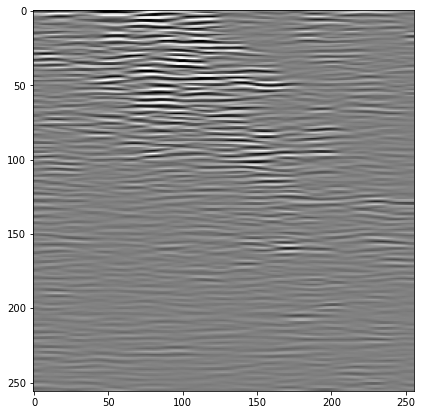

In [30]:
st = time.time()
for i in range(1):
    X,y = datamodule.train_ds[5]
print(time.time()-st)
plt.figure(figsize=(18.5/1.5, 10.5/1.5))
plt.imshow(X[0][0], 'gray', norm=NoNorm())

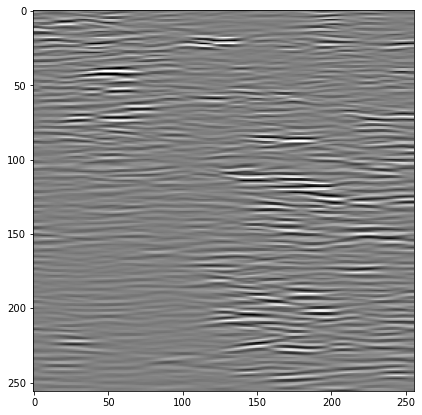

In [34]:
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))
x, y = batch
x = x[0]
x_tensor = x[0,0,...]
plt.figure(figsize=(18.5/1.5, 10.5/1.5))
plt.imshow(x_tensor, 'gray')

#### applying transformations

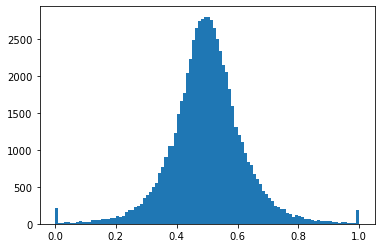

In [11]:
m = 5
n = 6
img = np.copy(x[m:n,0,...].numpy())
img = img.reshape(n-m,-1)
img = rearrange(img, 'b pix-> pix b')
plt.hist(img, bins=100)
plt.show()

tensor(0.5000) tensor(0.1003)


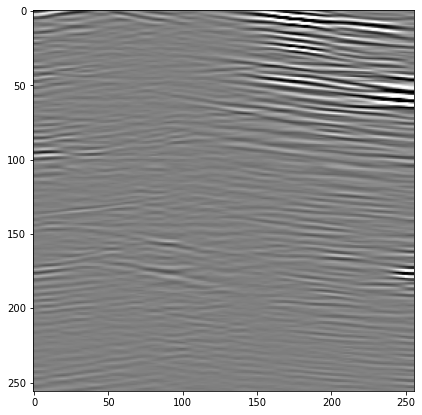

In [13]:
img = x[2,...].numpy()
# img = (img - np.mean(img, ))/np.std(img, )

transforms_ = aug_transforms('train', ['RandomHorizontalFlip'], p=0.)
img2 = apply_transforms(img, transforms_)

# img = rearrange(img, 'c h w -> h w c')
# img[img > 4] = 4.
# img[img < -4] = -4.
# img = (img - img.min()) / (img.max() - img.min())

# transforms_ = transforms.Compose(
#     [transforms.ToTensor(), transforms.RandomErasing(1., scale=(0.01, 0.05),ratio=(0.3, 3.3), value=0)]
# )

# img2 = transforms_(np.copy(img))
# img2 = (img2 - torch.mean(img2, ))/torch.std(img2, )
# img2 = (img2 - .24708273)/848.8191
print(img2.mean(), img2.std())
plt.figure(figsize=(18.5/1.5, 10.5/1.5))
plt.imshow(img2[0], 'gray', norm=NoNorm())

In [ ]:
img2 = img2[0,...].numpy()
img = img[:,:,0]

### finding mean and standard deviation of training + val data

In [ ]:
dataset_hyp = {'patch_sz':5, 'jump_sz':1, 'inv_cutoff':0.4}
dataset_hyp = munch.Munch(dataset_hyp)
datamodule = ExactDataModule(data_dir,batch_size=4000, dataset_hyp=dataset_hyp)
datamodule.prepare_data()
datamodule.setup()

In [ ]:
train_loader = datamodule.train_dataloader()
val_loader, = datamodule.val_dataloader()
batch_train = next(iter(train_loader))
batch_val = next(iter(val_loader))
x_train, y = batch_train
x_val, y = batch_val

In [ ]:
x = torch.cat([x_train, x_val])

In [ ]:
print(x.size())
all_x = x.numpy()
print(all_x.mean(), all_x.std())

## MNIST Datamodule

In [ ]:
from src.datamodules.mnist_datamodule import MNISTDataModule
from torchvision.datasets import MNIST
mnist_dir = 'C:\\Users\\Mahdi\\Desktop\\Shared_folder\\OneDrive_Queens_University\\Project_codes\\SSLmicroUltrasound\\data\\'
mnist_ds = MNIST(mnist_dir, train=True, download=False)
mnist_img, _ = mnist_ds.__getitem__(105)
plt.imshow(mnist_img, 'gray')
tensor_mnist = np.array(mnist_img)

In [ ]:
transforms_ = transforms.Compose([transforms.ToTensor(), transforms.RandomInvert(p=1.),transforms.Normalize((0.1307,), (0.3081,))])
tensor_mnist2 = transforms_(tensor_mnist).numpy()
print(tensor_mnist2.mean(), tensor_mnist2.std())
plt.imshow(tensor_mnist2[0,:,:], 'gray', norm=NoNorm())

# NEW DATAMODULE written by Paul

In [2]:
# Datamodule Usage Demo
import dotenv
dotenv.load_dotenv()

True

In [3]:
from exactvu.data.datamodules import MICCAI2022DataModule
%env DATA=../data/Exact/
dm = MICCAI2022DataModule(needle_region_intersection_threshold=0.7)

env: DATA=../data/Exact/


In [4]:
dm.prepare_data()

In [5]:
dm.setup()

In [6]:
dm.train_dataloader()

In [7]:
dm.train_dataset.metadata

,patient_id,loc,split,center,grade,age,family_history,psa,pct_cancer,primary_grade,secondary_grade,directory
2,436,LAL,train,UVA,Benign,59,True,10.01,NaN,NaN,NaN,UVA-0436_LAL_Benign
3,315,RBM,train,UVA,Benign,60,NaN,5.36,NaN,NaN,NaN,UVA-0315_RBM_Benign
4,595,RBL,train,UVA,Benign,57,True,6.42,NaN,NaN,NaN,UVA-0595_RBL_Benign
9,599,RBM,train,UVA,Benign,65,False,9.64,NaN,NaN,NaN,UVA-0599_RBM_Benign
10,480,LAM,train,UVA,Benign,71,False,7.13,NaN,NaN,NaN,UVA-0480_LAM_Benign
...,...,...,...,...,...,...,...,...,...,...,...,...
595,590,LMM,val,UVA,GS7,66,False,14.08,30.0,3.0,4.0,UVA-0590_LMM_GS7
596,590,RAL,val,UVA,GS7,66,False,14.08,70.0,3.0,4.0,UVA-0590_RAL_GS7
597,590,RAM,val,UVA,GS8,66,False,14.08,50.0,4.0,4.0,UVA-0590_RAM_GS8
598,590,RBL,val,UVA,GS7,66,False,14.08,90.0,3.0,4.0,UVA-0590_RBL_GS7


In [ ]:
st = time.time()
for i in range(1):
    X, y = dm.train_dataset[500]
print(time.time()-st)

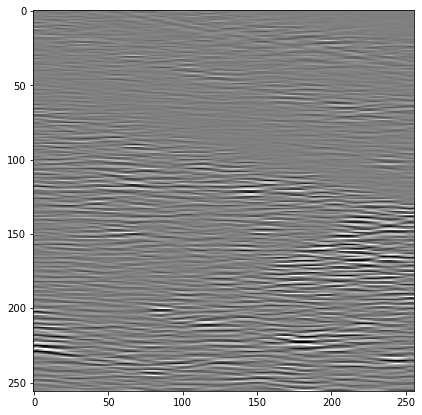

In [40]:
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
plt.figure(figsize=(18.5/1.5, 10.5/1.5))
plt.imshow(X.numpy()[0], 'gray')

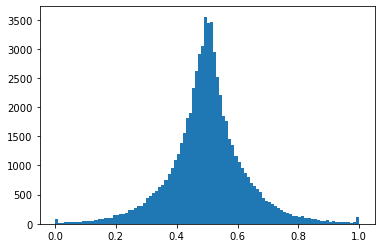

In [40]:
img = X[0].reshape(-1).numpy()
img.shape
plt.hist(img, bins=100)
plt.show()

In [33]:
dm.train_dataset.get_metadata(3)

{'patient_id': 9,
 'loc': 'LBM',
 'split': 'train',
 'center': 'UVA',
 'grade': 'Benign',
 'age': 63,
 'family_history': False,
 'psa': 31.0,
 'pct_cancer': nan,
 'primary_grade': nan,
 'secondary_grade': nan,
 'directory': 'UVA-0009_LBM_Benign',
 'core_index': 0,
 'patch_index': 1}

top left:  (13, 28)


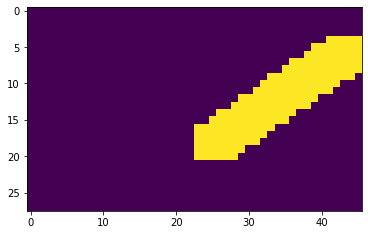

In [10]:
core_idx, patch_idx = dm.train_dataset.get_core_and_patch_idx(3000)
core = dm.train_dataset.cores[core_idx]

print('top left: ', core.patch_positions[patch_idx])
plt.imshow(core.patch_mask)

In [1]:
from exactvu.data.datamodules import MICCAI2022DataModule

%env DATA=../data/Exact/
dm = MICCAI2022DataModule(mode='self-supervised',  aug_prob=0.8)
dm.prepare_data()  # this line will take no time to run as the data is already downloaded
dm.setup()

env: DATA=../data/Exact/


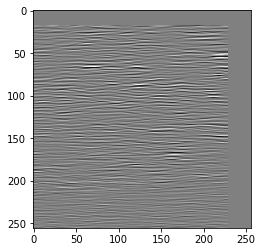

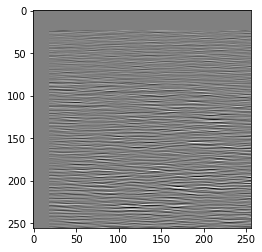

In [16]:
X, target = dm.train_dataset[0]
X1, X2 = X
plt.imshow(X1.numpy()[0], 'gray')
plt.figure()
plt.imshow(X2.numpy()[0], 'gray')